# Special Session: Noise Characterization and Error Mitigation in Near-Term Quanutm Computers

* Christopher J. Wood (cjwood@us.ibm.com)
* IBM Quantum, T. J. Watson Research Center, Yorktown Heights, USA

This notebook contains the accompanying code to the ICCD 2020 special session proceeding *Noise Characterization and Error Mitigation in Near-Term Quantum Computers*.

## 3. Measurement Error Characterization

This notebook demonstrates performing measurement error characterization on a 4-qubit subset of an IBM Quantum device using the continous-time Markov Process (CTPM) error mitigation technique.

In [1]:
# Qiskit Module
import qiskit
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Noisy Simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

# File utilities for saving and loading JSON data
from file_utils import save_to_json, load_properties, load_result

# Other
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

## Measurement Error Characterization

Measurement error characterization circuits can be generated using the `mitigation` module of *qiskit-ignis*. To characterize measurement error we select the set of all weight-2 computational basis input states on 4-qubits, along with the all-0 and all-1 states,

In [2]:
labels = ['0000', '0011', '0101', '1001', '0110', '1010', '1100', '1111']
circuits, metadata = mit.expval_meas_mitigator_circuits(4, labels=labels)

### Run Experiment

Next execute the circuits on the IBM Quantum Boeblingen backend. You may change this to run on any IBM Quantum backend you have access to.

In [3]:
use_saved_data = True
file_properties = 'data/properties_meas_v1.json'
file_result = 'data/result_meas_v1.json'

if use_saved_data:

    # Load saved result data from file
    result_backend = load_result(file_result)

    # Load saved properties from file
    properties = load_properties(file_properties)

else:

    # Load IBMQ Account data
    from qiskit import IBMQ
    IBMQ.load_account()

    # Get backend for experiment
    provider = IBMQ.get_provider(project='ignis')
    backend = provider.get_backend('ibmq_boeblingen')

    # Run QPT on backend
    shots = 8192
    job_backend = qiskit.execute(circuits, backend, shots=shots)
    print('Job ID: {}'.format(job_backend.job_id()))

    # Save a copy of the backend properties to file
    properties = backend.properties()
    save_to_json(properties, file_properties)
          
    # Retrieve results (this may take a while depending on the queue)
    result_backend = job_backend.result()
    
    # Save a copy of the result data to file
    save_to_json(result_backend, file_result)    

### Run Simulation

Next we run the characterization experiment using the Qiskit Aer simulator with the basic device noise model based on the backend used to run the experiment

In [4]:
# Simulator backend
simulator = QasmSimulator()
shots = 8192
seed_simulator = 1984

# Noise Model
noise_model = NoiseModel.from_backend(properties, warnings=False)

# Run simulation
result_sim = qiskit.execute(circuits,
                            simulator,
                            shots=shots,
                            seed_simulator=seed_simulator,
                            basis_gates=noise_model.basis_gates,
                            noise_model=noise_model).result()

### Fitting Results

Next we perform the measurement mitigator fit of the calibration data. This is done using the `MeasMitigatorFitter`.

In [5]:
mitigator_backend = mit.ExpvalMeasMitigatorFitter(
    result_backend, metadata).fit(method='CTMP')

mitigator_sim = mit.ExpvalMeasMitigatorFitter(
    result_sim, metadata).fit(method='CTMP')

### Single-qubit Measurement Errors

From the mitigator we can compute the estimated single qubit measurement errors from the single-qubit $A$ matrices.

In [6]:
a1q_b = [mitigator_backend.assignment_matrix([i]) for i in range(4)]
a1q_s = [mitigator_sim.assignment_matrix([i]) for i in range(4)]
p0g1_b = [round(a[0, 1], 3) for a in a1q_b]
p1g0_b = [round(a[1, 0], 3) for a in a1q_b]
p0g1_s = [round(a[0, 1], 3) for a in a1q_s]
p1g0_s = [round(a[1, 0], 3) for a in a1q_s]

print('Single-qubit readout errors')
print(properties.backend_name)
print('P(1|0) = {}'.format(p1g0_b))
print('P(0|1) = {}'.format(p0g1_b))

print('simulated')
print('P(1|0) = {}'.format(p1g0_s))
print('P(0|1) = {}'.format(p0g1_s))

Single-qubit readout errors
ibmq_boeblingen
P(1|0) = [0.006, 0.005, 0.006, 0.012]
P(0|1) = [0.031, 0.034, 0.053, 0.034]
simulated
P(1|0) = [0.014, 0.01, 0.013, 0.011]
P(0|1) = [0.029, 0.06, 0.053, 0.028]


### Measurement Error Plot

To visualize the error of the calibrated mitigator we plot the absolute difference of the *assignment matrix* with the ideal case of the identity matrix $|A - I|$

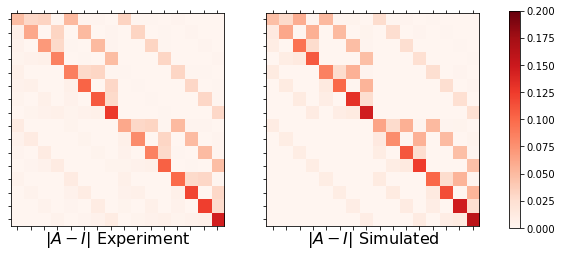

In [7]:
diff_b = np.abs(mitigator_backend.assignment_matrix() - np.eye(16))
diff_s = np.abs(mitigator_sim.assignment_matrix() - np.eye(16))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10.5, 4))

im2 = axes.flat[0].matshow(diff_b, cmap=plt.cm.Reds, vmin=0, vmax=0.2)
im2 = axes.flat[1].matshow(diff_s, cmap=plt.cm.Reds, vmin=0, vmax=0.2)

for ax in axes.flat:
    ax.set_yticks(np.arange(16))
    ax.set_xticks(np.arange(16))
    ax.set_yticklabels(16 * [''])
    ax.set_xticklabels(16 * [''])
axes.flat[0].set_xlabel(r'$|A - I|$ Experiment', fontsize=16)
axes.flat[1].set_xlabel(r'$|A - I|$ Simulated', fontsize=16)

fig.colorbar(im2, ax=axes.ravel().tolist())
fig.savefig('figures/amat_error.png', dpi=150)
plt.show()

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table